In [2]:
import os

from absl import app, flags
import jax
import jax.numpy as jnp
from ml_collections import config_flags
from orbax.checkpoint import CheckpointManager, CheckpointManagerOptions, PyTreeCheckpointer
import optax
from tqdm import tqdm
import wandb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from pathlib import Path

from ddprism.corrupted_mnist import datasets
from ddprism.metrics import metrics, image_metrics
from ddprism.pcpca import pcpca_utils

from ddprism.corrupted_mnist import config_base_grass, config_base_mnist
import config_base_pcpca


2025-07-18 17:10:45.869894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752873045.886248  982620 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752873045.891103  982620 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752873045.903699  982620 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752873045.903723  982620 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752873045.903724  982620 computation_placer.cc:177] computation placer alr

In [3]:

# Path to Imagenet dataset
imagenet_path = '/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/dataset/grass_jpeg/' 
classifier_path = Path('/mnt/home/swagner/ceph/corrupted_mnist/mnist_classifier/')

@partial(jax.jit, static_argnames=['batch_size'])
def get_loss_grad(params, x, y, gamma, regularization, batch_size=16):
    a_mat = jnp.eye(x.shape[-1])[None, ...]

    def calculate_loss_grad(data):
        x, y = data
        grad = pcpca_utils.loss_grad(
            params, x[None, ...], y[None, ...], a_mat, a_mat, gamma, regularization
        )
        return grad
    
    loss_grad = jax.lax.map(calculate_loss_grad, (x, y), batch_size=batch_size)
    return loss_grad
        

@partial(jax.jit, static_argnames=['batch_size'])
def get_loss(params, x, y, gamma, regularization, batch_size=16):
    a_mat = jnp.eye(x.shape[-1])
    
    def calculate_loss_grad(data):
        x, y = data
        loss = pcpca_utils.loss(
            params, x[None, ...], y[None, ...], a_mat, a_mat, gamma, regularization
        )
        return loss
        
    loss = jax.lax.map(calculate_loss, (x, y), batch_size=batch_size)
    return loss

@partial(jax.jit, static_argnames=['batch_size', 'img_dim'])
def get_posterior_samples(rng, params, x, y, mnist_amp, img_dim=28, batch_size=16):
    """Computes posterior samples for a given target dataset, given a dictionary of pcpca parameters.
    
    Returns:
        Posterior samples.
    
    """
    # ...
    a_mat = jnp.eye(x.shape[-1])
    bkg_mean = y.mean(axis=0)

    # Get individual random keys for each image.
    rng_post = jax.random.split(rng, x.shape[0])
    
    def calculate_posterior(x):
        return pcpca_utils.calculate_posterior(params, x, a_mat) 

    def post_samples(args):
        rng, x = args
        mean, sigma = calculate_posterior(x)
        return (jax.random.multivariate_normal(rng, mean, sigma) - bkg_mean) / mnist_amp
    
        
    post_samples = jax.lax.map(post_samples, (rng_post, x), batch_size=batch_size)
    return post_samples.reshape(-1, img_dim, img_dim, 1)

def get_prior_samples(rng, params, num_samples, latent_dim, feat_dim, bkg, mnist_amp, img_dim=28):
    """Computes posterior samples for a given target dataset, given a dictionary of pcpca parameters.
    
    Returns:
        Posterior samples.
    
    """
    # Draw latent vectors and noise vectors.
    rng_z, rng_eps, rng = jax.random.split(rng, 3)
    z_x = jax.random.multivariate_normal(
        rng_z, mean=jnp.zeros((num_samples, latent_dim)), cov=jnp.eye(latent_dim)
    )
    
    eps_x = jax.random.multivariate_normal(
        rng_eps, mean=jnp.zeros((num_samples, feat_dim)), cov = jnp.exp(params['log_sigma'])**2*jnp.eye(feat_dim)
    )
    # Compute prior samples for target dataset.
    prior_samples = ((params['weights'] @ z_x.T).T + params['mu'] + eps_x)
    
    # Subtract contribution due to the background signal and scale by the appropriate amplitude.
    prior_samples = (prior_samples - bkg.mean(axis=0)) / mnist_amp
    prior_samples = prior_samples.reshape(-1, img_dim, img_dim, 1)
    
    return prior_samples


# Iterate through batches

In [9]:
def run_pcpca(config_mnist, config_grass, config_pcpca, workdir):
    # Generate training datasets.
    # Target dataset with corrupted mnist digits.
    
    # RNG key from config.
    rng = jax.random.key(config_mnist.rng_key)
    
    # Set up wandb logging and checkpointing.
    wandb.init(
        config=config_pcpca.copy_and_resolve_references(),
        project=config_pcpca.wandb_kwargs.get('project', None),
        name=config_pcpca.wandb_kwargs.get('run_name', None),
        mode=config_pcpca.wandb_kwargs.get('mode', 'disabled')
    )
    
    rng_dataset, rng_comp, rng = jax.random.split(rng, 3)
    
    f_train = datasets.get_corrupted_mnist(
        rng_dataset, grass_amp=1., mnist_amp=config_mnist.mnist_amp,
        imagenet_path=imagenet_path,
        dataset_size=config_mnist.dataset_size,
        zeros_and_ones=True
    )
    # Target dataset with uncorrupted mnist digits for computing metrics later on.
    f_train_uncorrupted = datasets.get_corrupted_mnist(
        rng_dataset, grass_amp=0., mnist_amp=1.,
        imagenet_path=imagenet_path,
        dataset_size=config_mnist.dataset_size,
        zeros_and_ones=True
    )
    # Background dataset with grass only.
    #config_grass = config_base_grass.get_config()
    rng = jax.random.key(config_grass.rng_key)
    rng_dataset, rng_comp, rng = jax.random.split(rng, 3)
    b_train = datasets.get_corrupted_mnist(
        rng_dataset, grass_amp=1., mnist_amp=0.,
        imagenet_path=imagenet_path, 
        dataset_size=config_grass.dataset_size,
        zeros_and_ones=True)


    # Prepare data for PCPCA
    x, x_labels = f_train
    y, y_labels = b_train

    feat_dim = x.shape[-3]*x.shape[-2]*x.shape[-1] 
    x = x.squeeze(-1).reshape(-1, feat_dim)
    y = y.squeeze(-1).reshape(-1, feat_dim)

    # Initialize PCPCA params close to their ML estimates.
    weights_init = jnp.load('W_mle.npy') 
    weights_init += 1e-1*jax.random.normal(rng, shape=weights_init.shape)

    mu_init = jnp.load('mu_mle.npy')
    mu_init += 1e-1*jax.random.normal(rng, shape=mu_init.shape)
    
    log_sigma_init = jnp.log(config_grass.sigma_y)

    # Initialize parameters.
    params = {
        'weights': jnp.asarray(weights_init), 'log_sigma': log_sigma_init,
        'mu': jnp.asarray(mu_init)
    }

    # Optimization loop parameters.
    if config_pcpca.lr_schedule == 'linear':
        schedule = optax.schedules.linear_schedule(
                config_pcpca.learning_rate, 1e-6, config_pcpca.n_iter
            )
    elif config_pcpca.lr_schedule == 'cosine':
        schedule = optax.schedules.cosine_decay_schedule(
                init_value=config_pcpca.learning_rate, decay_steps=config_pcpca.n_iter
            )
    else:
        raise ValueError(
                f'Unknown learning rate schedule: {config_pcpca.lr_schedule}'
            )

    # Initialize Adam optimizer
    optimizer = optax.adam(learning_rate=schedule)
    opt_state = optimizer.init(params)

    # Run the optimization loop.
    pbar = tqdm(range(config_pcpca.n_iter),)
    
    steps_per_epoch = x.shape[0] // config_pcpca.batch_size 
    pbar_epoch = tqdm(range(steps_per_epoch),)
    
    regularization = 1e-6
    a_mat = jnp.repeat(jnp.eye(feat_dim)[None, ...], config_pcpca.batch_size, axis=0)
    losses = []
    for iter in pbar:
        for step in pbar_epoch:
            rng_epoch, rng = jax.random.split(rng, 2)
            
            batch_i = jax.random.randint(
                rng_epoch, shape=(config_pcpca.batch_size,), 
                minval=0, maxval=x.shape[0]
            )
            
            x_batch = x[batch_i]
            y_batch = y[batch_i]

            '''
            # This function takes longer to run than autograd
            grad = jax.jit(pcpca_utils.loss_grad)(
                params, x_batch, y_batch, a_mat, a_mat, config_pcpca.gamma, regularization
            )
            '''
            grad = jax.grad(pcpca_utils.loss, argnums=0, allow_int=True)(
                params, x_batch, y_batch, a_mat, a_mat, config_pcpca.gamma, regularization
            )
    
            loss = jax.jit(pcpca_utils.loss)(
                params, x_batch, y_batch, a_mat, a_mat, config_pcpca.gamma, regularization
            )
            
            
            # Update parameters
            updates, opt_state = optimizer.update(grad, opt_state, params)
            params = optax.apply_updates(params, updates)
            params['log_sigma'] = jnp.log(config_mnist.sigma_y) # Fix log_sigma.

            
            # Log our loss.
            wandb.log(
                {f'loss': loss},
            )
            
            pbar.set_postfix({'loss': f'{loss:.6f}'})
            losses.append(loss)
    
    # Get the posterior samples for MNIST digits.
    rng_post, rng = jax.random.split(rng, 2)
    post_samples  = get_posterior_samples(rng_post, params, x, y, config_mnist.mnist_amp) 

    # Get prior samples for MNIST digits.
    rng_prior, rng = jax.random.split(rng, 2)
    num_samples = x.shape[0]
    prior_samples = get_prior_samples(rng_prior, params, num_samples, config_pcpca.latent_dim, feat_dim, y, config_mnist.mnist_amp)

    # Plot the first few prior and posterior samples.
    # Posterior samples
    n_rows, n_cols = 3, 5
    
    idx = jnp.arange(10, 60, 10)
    fig, axs = plt.subplots(n_rows, n_cols)
    for col in range(n_cols):
        axs[0, col].imshow(post_samples.reshape(-1, 28, 28, 1)[idx[col]], vmin=0.0, vmax=1.0)
        axs[1, col].imshow(f_train_uncorrupted[0][idx[col]], vmin=0.0, vmax=1.0)
        axs[2, col].imshow(f_train[0][idx[col]], vmin=0.0, vmax=1.0)
    
    wandb.log(
        {f'posterior samples': wandb.Image(fig)},
        commit=False
    )


    # Prior samples
    idx = jnp.arange(10, 60, 10)
    fig, axs = plt.subplots(1, n_cols)
    for col in range(n_cols):
        axs[col].imshow(prior_samples.reshape(-1, 28, 28, 1)[idx[col]], vmin=0.0, vmax=1.0)
    
    wandb.log(
        {f'prior samples': wandb.Image(fig)},
        commit=False
    )


    print(post_samples.shape, prior_samples.shape)

    
    # Compute and log metrics.
    metrics_dict = {}
    x_uncorrupted = f_train_uncorrupted[0]
    
    # Compute FCD on posterior and prior samples.
    # Load classifier model to compute FCD.
    checkpointer = PyTreeCheckpointer()
    checkpoint_manager = CheckpointManager(classifier_path, checkpointer)
    classifier_model = image_metrics.CNN()
    classifier_params = checkpoint_manager.restore(checkpoint_manager.latest_step())['params'] 
    checkpoint_manager.close()
    
    fcd_post = image_metrics.fcd_mnist(
        classifier_model, 
        classifier_params, 
        x_uncorrupted, 
        post_samples
    )

    wandb.log(
            {'fcd_post': fcd_post}, commit=False
        )

    
    fcd_prior = image_metrics.fcd_mnist(
        classifier_model, 
        classifier_params, 
        x_uncorrupted, 
        prior_samples
    )

    wandb.log(
            {'fcd_prior': fcd_prior}, commit=False
        )


    # Compute PSNR.
    psnr_post = metrics.psnr(
            post_samples[:config_mnist.psnr_samples],
            x_uncorrupted[:config_mnist.psnr_samples],
            max_spread=config_mnist.MAX_SPREAD
    )
    
    wandb.log(
            {'psnr_post': psnr_post}, commit=False
    )
    
    
    psnr_prior = metrics.psnr(
            prior_samples[:config_mnist.psnr_samples],
            x_uncorrupted[:config_mnist.psnr_samples],
            max_spread=config_mnist.MAX_SPREAD
    )
    
    wandb.log(
            {'psnr_prior': psnr_prior}, commit=False
    )
  

    # Compute PQMAss.
    pqmass_post = metrics.pq_mass(
        post_samples[:config_mnist.pq_mass_samples],
        x_uncorrupted[:config_mnist.pq_mass_samples]
    )
    
    wandb.log(
            {'pqmass_post': pqmass_post}, commit=False
    )
    
    pqmass_prior = metrics.pq_mass(
        prior_samples[:config_mnist.pq_mass_samples],
        x_uncorrupted[:config_mnist.pq_mass_samples]
    )

    wandb.log(
            {'pqmass_prior': pqmass_prior}, commit=False
    )
    

    # Save parameters to a checkpoint.
    checkpointer = PyTreeCheckpointer()
    checkpoint_options = CheckpointManagerOptions(
        enable_async_checkpointing=False
    )
    checkpoint_manager = CheckpointManager(
        os.path.join(workdir, 'checkpoints'), checkpointer,
        options=checkpoint_options
    )
    checkpoint_manager.save(0, params)
    checkpoint_manager.close()
    
    # Record performance metrics (FCD, PSNR, PQMass).
    metrics_dict['fcd_post'] = float(fcd_post)
    metrics_dict['fcd_prior'] = float(fcd_prior)
    
    metrics_dict['psnr_post'] = float(psnr_post)
    metrics_dict['psnr_prior'] = float(psnr_prior)
    
    metrics_dict['pqmass_post'] = float(pqmass_post)
    metrics_dict['pqmass_prior'] = float(pqmass_prior)

    wandb.finish()
    
    
    return params, losses, metrics_dict


In [ ]:
import importlib
importlib.reload(pcpca_utils)

from ml_collections import ConfigDict

workdir = '/mnt/home/aakhmetzhanova/ceph/pcpca_mnist/'
os.makedirs(workdir, exist_ok=True)

config_pcpca = config_base_pcpca.get_config()

config_mnist = config_pcpca.config_mnist
config_grass = config_pcpca.config_grass

config_pcpca.lr_schedule = 'linear'
config_pcpca.learning_rate = 1e-6
config_pcpca.n_iter = 10

config_pcpca.batch_size = 64

config_pcpca.wandb_kwargs = ConfigDict(
        {
            'project': 'pcpca-mnist-downsample', 'mode': 'online',
            'run_name': None
        }
    )

params, losses, metrics_dict = run_pcpca(config_mnist, config_grass, config_pcpca, workdir)

wandb: Currently logged in as: aakhmetzhanova to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /mnt/home/aakhmetzhanova/ddprism/ddprism/corrupted_mnist/baselines/pcpca/wandb/run-20250718_173622-ir0mk1v1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run stoic-bee-1
wandb: ⭐️ View project at https://wandb.ai/aakhmetzhanova/pcpca-mnist-downsample
wandb: 🚀 View run at https://wandb.ai/aakhmetzhanova/pcpca-mnist-downsample/runs/ir0mk1v1
 90%|█████████ | 9/10 [14:42<01:29, 89.29s/it, loss=-80829.500000]  

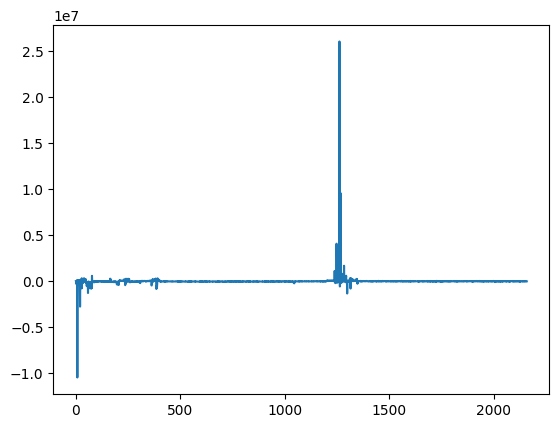

In [7]:
plt.plot(losses)